# Projekt
Uruchomimy nasze środkowisko z losowymi ruchami by zobaczyć czy nasze środkowisku poprawnie się tworzy

In [1]:
import gym
import game2048
import numpy as np
import os.path
from stable_baselines3 import A2C, PPO, DQN
import matplotlib.pyplot as plt

from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import ProgressBarCallback
from stable_baselines3.common.vec_env import VecFrameStack


In [ ]:

env = gym.make('envs/game2048-v0',reward_type=2, render_mode='human')

env.action_space.seed(42)

observation = env.reset(seed=42)

max_random_reward = 0

for _ in range(100):
    observation, reward, terminated, info = env.step(env.action_space.sample())
    max_random_reward = max(max_random_reward, reward)
    # print(f"Reward: {info.get('reward')}")
    # print(f"observation: {observation}")
    if terminated:
        print(f"reward: {reward}")
        print(info.get('board'))
    if terminated:
        observation = env.reset()

env.close()

print(f"Max random reward: {max_random_reward}")

## Przykładowy widok planszy w trybie wyświetlania "human"
![view](project/Images/example.png)

# Stable Baselines
Użyjemy gotowych modeli pobranych z paczki Stable Baselines

Nasza nagroda zdefiniowana jest jako suma wszystkich bloków na planszy podzielona przez 4096 by zachować ją w przedziale [0-1]

Jak możemy zauważyć nasz model ustawia na dolnych polach 16, wyższych 8, drugich 4 a najwyższych 2 a potem przegrywa. Spróbujmy wykorzystać inną metodę liczenia nagrody (do tej pory używaliśmy sumy wszystkich pól). Teraz wykorzystamy jako nagrodę wartość największego pola

In [2]:
models_dir = "models/A2C"
logdir = "logs"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

In [23]:
def train_model(reward_type=0, observation_mode=1, TIMESTEPS=10_000, nr_of_enviroments=1, death_on_illeagl_moves=True):
    env = gym.make("envs/game2048-v0", reward_type=reward_type, observation_mode=observation_mode, death_on_illeagl_moves=death_on_illeagl_moves)

    model = A2C("MlpPolicy", env, verbose=1, tensorboard_log=logdir)


    for i in range(1,30):
        model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="A2C_reward_type=" + str(reward_type) + "obs_mode" + str(observation_mode))
        model.save(f"{models_dir}/reward_type_{reward_type}/obs_mode{observation_mode}/{TIMESTEPS*i}")

    return model, env


In [3]:
TIMESTEPS = 50_000

In [25]:
model0, env0 = train_model(reward_type=0, observation_mode=0, TIMESTEPS=TIMESTEPS)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\A2C_reward_type=0obs_mode0_0
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 19.3      |
|    ep_rew_mean        | -1.64e+04 |
| time/                 |           |
|    fps                | 361       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -1.38     |
|    explained_variance | -0.0686   |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 0.073     |
|    value_loss         | 0.00329   |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 19.5      |
|    ep_rew_mean        | -1.64e+04 |
| time/                 |           |
|    fps                

C:\Users\Pawla\Documents\Studia\Python\ml2022-23\venv\lib\site-packages\stable_baselines3\common\save_util.py:278: UserWarning: Path 'models\A2C\reward_type_0\obs_mode0' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 15.3      |
|    ep_rew_mean        | -1.64e+04 |
| time/                 |           |
|    fps                | 427       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 50500     |
| train/                |           |
|    entropy_loss       | -1.38     |
|    explained_variance | -3.39e-05 |
|    learning_rate      | 0.0007    |
|    n_updates          | 10099     |
|    policy_loss        | -2.21e+04 |
|    value_loss         | 2.58e+08  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 15.6      |
|    ep_rew_mean        | -1.64e+04 |
| time/                 |           |
|    fps                | 432       |
|    iterations         | 200       |
|    time_elapsed       | 2         |
|    total_timesteps    | 51000     |
| train/    

KeyboardInterrupt: 

![view](project/Images/tensorboard1.png)

Jak możemy łatwo zauważyć z wykresu na TensorBoard nasz model nie nauczył się praktycznie nic, średnia nagroda jest niemal cały czasn na ujemnym poziomie co oznacza że model wykonuje nielgalne ruchy (nie zmieniające planszy). Był krótki moment gdy ta metryka się podniosła, ale wciąż za mało. Jest to związane nie z samą funkcją nagrody, lecz z tym w jaki sposób zwracamy planszę (by przeskalować planszę by każde pole mieściło się z zakresu od 0 do 1 zwracam planszę podzieloną przez 2048). Najproawdopodniej liczby te są zbyt małe dla sieci neuronowej, moglibyśmy każde pole zlogarytmować ale jest nawet lepszą choć mniej wydajną reprezentację. Podzielimy naszą plansze na 16 kanałów (macierz 2d w 3d) i na j-tym kanale 1 oznacza występowania płytki z wartością 2^j

In [ ]:
model1, env1 = train_model(reward_type=0,TIMESTEPS=TIMESTEPS)

Naszemu modelowi idzie trochę lepiej, ale wciąż średnia nagroda jest niska. Model musi się nauczyć że nie jest w stanie wykonać niektóych ruchów co może zając mu dużo czasu. Zamiast tego możemy pomijać takie ruchy. Takie "oszukiwanie" jest częstą rzeczą wykorzystywaną w ML by przyśpieszyć/ułatwić proces uczenia modelu

In [ ]:
model2, env2 = train_model(reward_type=1,TIMESTEPS=TIMESTEPS, death_on_illeagl_moves=False)

In [ ]:
model3, env3 = train_model(reward_type=2,TIMESTEPS=TIMESTEPS, death_on_illeagl_moves=False)

Jednak mechanizm takiego oszukiwania może również negatywnie wpływać na nasz model. Np w tym przypadku model ustawia planszę w bardzo specyficznej pozycji i "zamraża ją" wykonując ruchy które nie zmieniają pozycji
![view](project/Images/stalemate.png)

Możemy w takiej sytuacji zmienijszyć nagrodę bez zabijania gry


In [26]:
model4, env4 = train_model(reward_type=3,TIMESTEPS=TIMESTEPS, death_on_illeagl_moves=False)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\A2C_reward_type=3obs_mode1_0
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 124      |
|    ep_rew_mean        | 1.36e+03 |
| time/                 |          |
|    fps                | 365      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.38    |
|    explained_variance | 0.000145 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 218      |
|    value_loss         | 4.38e+04 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 117      |
|    ep_rew_mean        | 1.3e+03  |
| time/                 |          |
|    fps                | 384      |
|    iter

C:\Users\Pawla\Documents\Studia\Python\ml2022-23\venv\lib\site-packages\stable_baselines3\common\save_util.py:278: UserWarning: Path 'models\A2C\reward_type_3\obs_mode1' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 139      |
|    ep_rew_mean        | 1.81e+03 |
| time/                 |          |
|    fps                | 414      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 50500    |
| train/                |          |
|    entropy_loss       | -0.539   |
|    explained_variance | 5.02e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 10099    |
|    policy_loss        | 7.83     |
|    value_loss         | 367      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 140      |
|    ep_rew_mean        | 1.86e+03 |
| time/                 |          |
|    fps                | 418      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 51000    |
| train/                |          |
|

In [27]:
model5, env5 = train_model(reward_type=4,TIMESTEPS=TIMESTEPS, death_on_illeagl_moves=False)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\A2C_reward_type=4obs_mode1_0
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 152      |
|    ep_rew_mean        | 1.36e+03 |
| time/                 |          |
|    fps                | 392      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.38    |
|    explained_variance | 0.000449 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 39.4     |
|    value_loss         | 1.49e+03 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 139      |
|    ep_rew_mean        | 1.2e+03  |
| time/                 |          |
|    fps                | 429      |
|    iter

C:\Users\Pawla\Documents\Studia\Python\ml2022-23\venv\lib\site-packages\stable_baselines3\common\save_util.py:278: UserWarning: Path 'models\A2C\reward_type_4\obs_mode1' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 132       |
|    ep_rew_mean        | 1.23e+03  |
| time/                 |           |
|    fps                | 403       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 50500     |
| train/                |           |
|    entropy_loss       | -1.03     |
|    explained_variance | -1.43e-06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 10099     |
|    policy_loss        | 11.1      |
|    value_loss         | 324       |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 133      |
|    ep_rew_mean        | 1.26e+03 |
| time/                 |          |
|    fps                | 418      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 51000    |
| train/             

Możemy przyśpieszyć proces uczenia w stable baselines z użyciem Vectorized Environments. Zamiast ćwienia naszego agenta po jednym korku na raz tworzymy n środowisk (gier) i ćwiczymy naszego agenta na n grach na raz.

In [28]:
def train_model_multiple_enviroments(TIMESTEPS, reward_type=5, n_envs=4):
    env = make_vec_env("envs/game2048-v0", n_envs=n_envs)
    model = A2C("MlpPolicy", env, verbose=1, tensorboard_log=logdir)


    for i in range(1,30):
        model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="A2C_conc_reward_type=" + str(reward_type) + "obs_mode" + str(2))
        model.save(f"{models_dir}/reward_type_{reward_type}/obs_mode{2}/{TIMESTEPS*i}")

    return model, env

In [29]:
model6, env6 = train_model_multiple_enviroments(TIMESTEPS=TIMESTEPS*15, reward_type=5, n_envs=4)

Using cuda device
Logging to logs\A2C_conc_reward_type=5obs_mode2_0
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 17.2      |
|    ep_rew_mean        | -1.64e+04 |
| time/                 |           |
|    fps                | 1442      |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 2000      |
| train/                |           |
|    entropy_loss       | -1.38     |
|    explained_variance | 7.75e-05  |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -2.25e+03 |
|    value_loss         | 2.66e+07  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 17.7      |
|    ep_rew_mean        | -1.64e+04 |
| time/                 |           |
|    fps                | 1448      |
|    iterations         | 200       |
|    time_elapsed   

KeyboardInterrupt: 

In [2]:
def show_model(model, env, n):
    obs = env.reset()
    for i in range(n):
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        env.render('human')
        if done:
            env.reset()
    env.close()

In [3]:
model1 = A2C.load("models/A2C/reward_type_0/obs_mode0/650000.zip")
env1 = gym.make('envs/game2048-v0',reward_type=0, observation_mode=0)

pygame 2.1.0 (SDL 2.0.16, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
model2 = A2C.load("models/A2C/reward_type_1/obs_mode1/1450000.zip")
env2 = gym.make('envs/game2048-v0',reward_type=1)

In [5]:
model3 = A2C.load("models/A2C/reward_type_2/1450000.zip")
env3 = gym.make('envs/game2048-v0',reward_type=2, observation_mode=0)

In [6]:
model4 = A2C.load("models/A2C/reward_type_3/obs_mode1/1450000.zip")
env4 = gym.make('envs/game2048-v0',reward_type=3)

In [7]:
model5 = A2C.load("models/A2C/reward_type_4/obs_mode1/1450000.zip")
env5 = gym.make('envs/game2048-v0',reward_type=4)

In [8]:
model6 = A2C.load("models/A2C/reward_type_5/obs_mode2/8250000.zip")
env6 = gym.make('envs/game2048-v0',reward_type=5)

In [9]:
model7 = DQN.load("models/DQN/5600000.zip")
env7 = gym.make('envs/game2048-v0',reward_type=5)

C:\Users\Pawla\Documents\Studia\Python\ml2022-23\venv\lib\site-packages\stable_baselines3\common\buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.06GB > 0.60GB
  warnings.warn(


In [10]:
model8 = PPO.load("models/PPO/3200000.zip")
env8 = gym.make('envs/game2048-v0',reward_type=5)

In [13]:
show_model(model6, env6, 1000)

KeyboardInterrupt: 

In [14]:
show_model(model7, env7, 1000)


KeyboardInterrupt: 

In [38]:
def test_win_rate(model, env):
    obs = env.reset()
    biggest_tiles = []
    sum_of_tiles = []
    for i in range(100):
        done = False
        while not done:
            action, _states = model.predict(obs)
            obs, rewards, done, info = env.step(action)
        biggest_tiles.append(info.get('highest_tile'))
        sum_of_tiles.append(np.sum(info.get('board')))
    return np.max(biggest_tiles), np.mean(biggest_tiles), np.mean(sum_of_tiles)

In [39]:
model1_max, model1_mean, mean_of_sum1 = test_win_rate(model1, env1)
model2_max, model2_mean, mean_of_sum2 = test_win_rate(model2, env2)
model3_max, model3_mean, mean_of_sum3 = test_win_rate(model3, env3)
model4_max, model4_mean, mean_of_sum4 = test_win_rate(model4, env4)
model5_max, model5_mean, mean_of_sum5 = test_win_rate(model5, env5)
model6_max, model6_mean, mean_of_sum6 = test_win_rate(model6, env6)
model7_max, model7_mean, mean_of_sum7 = test_win_rate(model7, env7)
model8_max, model8_mean, mean_of_sum8 = test_win_rate(model8, env8)

[64, 128, 128, 256, 128, 512, 64, 256]
[64.0, 128.0, 128.0, 256.0, 128.0, 512.0, 64.0, 256.0]


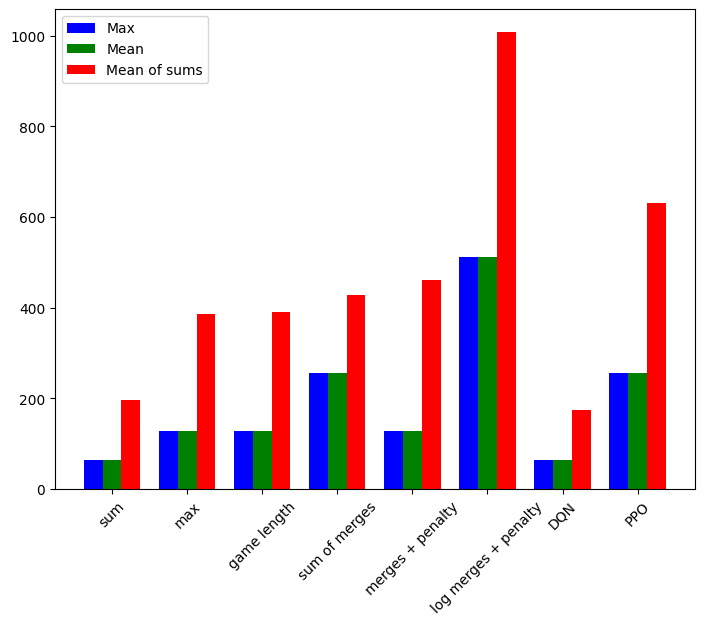

In [40]:
reward_types = ["sum", "max", "game length", "sum of merges", "merges + penalty", "log merges + penalty", "DQN", "PPO"]
max_rates = [model1_max, model2_max, model3_max, model4_max, model5_max, model6_max, model7_max, model8_max]
mean = [model1_mean, model2_mean, model3_mean, model4_mean, model5_mean, model6_mean, model7_mean, model8_mean]
mean_of_sums = [mean_of_sum1, mean_of_sum2, mean_of_sum3, mean_of_sum4, mean_of_sum5, mean_of_sum6, mean_of_sum7, mean_of_sum8 ]
print(max_rates)
print(mean)

X = np.arange(8)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, max_rates, color = 'b', width = 0.25)
ax.bar(X + 0.25, mean, color = 'g', width = 0.25)
ax.bar(X + 0.5, mean_of_sums, color = 'r', width = 0.25)
plt.legend(["Max", "Mean", "Mean of sums"],loc=2)
plt.xticks(X + 0.25, reward_types, rotation=45)


plt.show()

## Dodatek
Jeśli ktoś byłby zainteresowany to matematyką 2048 to zapraszam na stronę https://jdlm.info/articles/2018/03/18/markov-decision-process-2048.html